In [6]:
import spacy
import re
from bs4 import BeautifulSoup
import unicodedata
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer

In [8]:
nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [39]:
text = "In some studies, a significant percentage of patients with CAP are transferred to the ICU in the first 24–48 h after hospitalization."

In [40]:
otr = "Mortality and morbidity among these patients appears to be greater than those among patients admitted directly to the ICU. Conversely, ICU resources are often overstretched in many institutions, and the admission of patients with CAP who would not directly benefit from ICU care is also problematic. Unfortunately, none of the published criteria for severe CAP adequately distinguishes these patients from those for whom ICU admission is necessary. In the present set of guidelines, a new set of criteria has been developed on the basis of data on individual risks, although the previous ATS criteria format is retained. In addition to the 2 major criteria (need for mechanical ventilation and septic shock), an expanded set of minor criteria (respiratory rate, 130 breaths/min; arterial oxygen pressure/fraction of inspired oxygen (PaO2/FiO2) ratio, !250; multilobar infiltrates; confusion; blood urea nitrogen level, 120 mg/dL; leukopenia resulting from infection; thrombocytopenia; hypothermia; or hypotension requiring aggressive fluid resuscitation) is proposed (table 4). The presence of at least 3 of these criteria suggests the need for ICU care but will require prospective validation."

In [41]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text
simple_stemmer(text)

'In some studies, a signific percentag of patient with cap are transfer to the icu in the first 24–48 h after hospitalization.'

In [42]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
lemmatize_text(text)

'in some study , a significant percentage of patient with CAP be transfer to the ICU in the first 24–48 h after hospitalization .'

In [43]:
text_nlp = nlp(text)
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in text_nlp]
nltk_pos_tagged = nltk.pos_tag(text.split())

In [44]:
from nltk.corpus import conll2000
data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))

10900 48


In [45]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [46]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

In [47]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

# define the chunker class
class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)
  
# train chunker model  
ntc = NGramTagChunker(train_data)

# evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [48]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (PP In/IN)
  (NP some/DT studies,/NN)
  (NP a/DT significant/JJ percentage/NN)
  (PP of/IN)
  (NP patients/NNS)
  (PP with/IN)
  (NP CAP/NNP)
  (VP are/VBP transferred/VBN to/TO)
  (NP the/DT ICU/NNP)
  (PP in/IN)
  (NP the/DT first/JJ 24–48/CD h/NN)
  (PP after/IN)
  (NP hospitalization./NN))


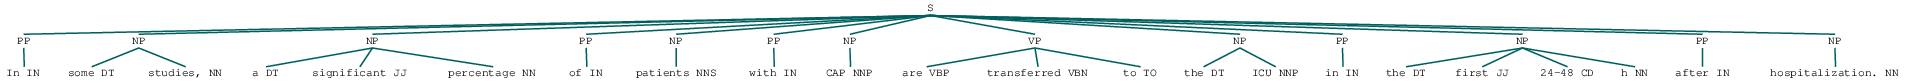

In [49]:
display(chunk_tree)